# Volano

### Set

In [1]:
# import glob
import math
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
graph_base_name = '../grafici/graph_'

style = ['white', 'dark', 'whitegrid', 'darkgrid', 'ticks'][2]
sns.set_style(style)

In [3]:
palette = sns.husl_palette(18)
print(' ', [' '+str(x) for x in range(6)],' ', [' '+str(x+6) for x in range(6)], ['_'+str(x+12) for x in range(6)])
palette

  [' 0', ' 1', ' 2', ' 3', ' 4', ' 5']   [' 6', ' 7', ' 8', ' 9', ' 10', ' 11'] ['_12', '_13', '_14', '_15', '_16', '_17']


[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9707505829046977, 0.4626541987597626, 0.26486329418330007),
 (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 (0.5310702086647983, 0.6569113639885688, 0.1931838276161326),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.1998437102815942, 0.6927711055021983, 0.4485948481767363),
 (0.20582072623426667, 0.6842209016721069, 0.5675558225732941),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 (0.22126158707091403, 0.6600977737826563, 0.7915486637100363),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5392573577708815, 0.5821140171749066, 0.9584212824085171),
 (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9614880299080136, 0.3909885385134758, 0.8298287106954371),
 (0.9648889414626248, 0.41896694790705413, 0.692031255809005)]

### Import

In [4]:
df = pd.read_csv('MisureVolano.txt', sep='\t')

In [5]:
arr_acc = df.query('Fase == "acc"').Tempo.to_numpy().reshape((10,12))
arr_dec = df.query('Fase == "dec"').Tempo.to_numpy().reshape((10,6))

## Accelerazione

### Media

In [6]:
def fn_sdom(arr):
    mean = np.mean(arr)
    sum = np.sum((arr-mean)**2)
    std = (sum / (arr.size - 1)) ** .5
    return std / (arr.size) ** .5


In [7]:
acc_mean = arr_acc.mean(axis=0)

In [8]:
acc_sdom = np.apply_along_axis(fn_sdom, 0, arr_acc)

In [9]:
acc_mean

array([15.6802 , 22.4146 , 27.4983 , 31.74836, 35.4952 , 38.96553,
       42.1331 , 45.17433, 48.01526, 50.65523, 53.21699, 55.61401])

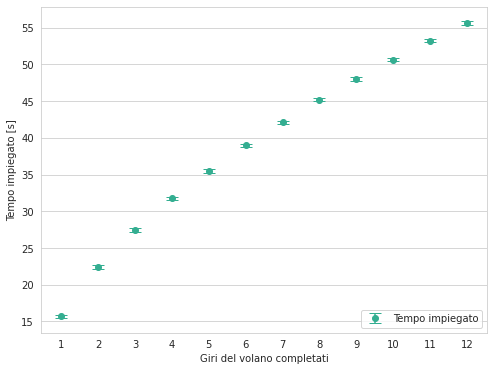

In [10]:
def plot_0acc():    
    plt.figure(figsize=(8,6))

    plt.errorbar(range(1,13), acc_mean, acc_sdom, fmt='o', capsize=6, color=palette[8], label='Tempo impiegato')

    plt.gca().grid(axis='x')

    plt.xlabel('Giri del volano completati')
    plt.ylabel('Tempo impiegato [s]')

    plt.xticks(range(1,13))
    
    plt.legend(loc='lower right')

    plt.savefig('../grafici/graph_acc_tempo', dpi=200)

plot_0acc()

### Differenza di tempo

In [11]:
acc_diff = np.apply_along_axis(
    lambda arr: np.convolve(arr, [1,-1], 'same'),
    0,
    acc_mean
)

In [12]:
acc_diff

array([15.6802 ,  6.7344 ,  5.0837 ,  4.25006,  3.74684,  3.47033,
        3.16757,  3.04123,  2.84093,  2.63997,  2.56176,  2.39702])

#### Errore

In [13]:
acc_sdom

array([0.20478754, 0.21264575, 0.28244198, 0.24068054, 0.22015435,
       0.2010395 , 0.21291077, 0.2230632 , 0.22839382, 0.20844398,
       0.2206878 , 0.23064632])

In [14]:
acc_sdom_roll = np.roll(acc_sdom, 1, axis=0)
acc_sdom_roll[0] = 0

In [15]:
acc_diff_sigma = np.sqrt(acc_sdom**2 + acc_sdom_roll**2)
acc_diff_sigma

array([0.20478754, 0.29522221, 0.35354163, 0.3710803 , 0.32618255,
       0.29813557, 0.29282739, 0.30836373, 0.31925057, 0.30921292,
       0.30356548, 0.31921909])

### Velocità media angolare

In [16]:
acc_vang = 2 * np.pi / acc_diff
acc_vang

array([0.40070824, 0.93299853, 1.2359473 , 1.47837567, 1.67692917,
       1.81054404, 1.98359793, 2.06600136, 2.21166495, 2.38002148,
       2.45268304, 2.62124859])

In [17]:
acc_vang_sig = acc_diff_sigma * 2 * np.pi / acc_diff ** 2
acc_vang_sig

array([0.00523336, 0.04090073, 0.08595291, 0.12907961, 0.14598569,
       0.15554359, 0.18337458, 0.209481  , 0.24853668, 0.27876582,
       0.29063999, 0.34908036])

### Fit

In [18]:
def fit(X,Y):
    N = X.size
    DELTA = N * (X ** 2).sum() - (X.sum()) ** 2
    a = ((X**2).sum()*(Y.sum()) - (X.sum())*(X*Y).sum()) / DELTA # q
    b = (N*(X*Y).sum() - (X.sum())*(Y.sum())) / DELTA            # m
    #
    SIGy = ((((a+b*X)-Y)**2).sum()/ (N-2)) ** .5
    SIGa = SIGy * ((X**2).sum() / DELTA) ** .5
    SIGb = SIGy * (N / DELTA) ** .5
    return a, SIGa, b, SIGb

In [19]:
def fit_pes(X,Y,Ysig):
    Ypes = 1 / Ysig ** 2

    N = X.size
    DELTA = Ypes.sum()*(Ypes*X**2).sum() - (Ypes*X).sum() ** 2

    a = ((Ypes*X**2).sum()*(Ypes*Y).sum() - (Ypes*X).sum()*(Ypes*X*Y).sum()) / DELTA    # q
    b = (Ypes.sum()*(Ypes*X*Y).sum() - (Ypes*X).sum()*(Ypes*Y).sum()) / DELTA           # m
    #
    SIGy = ((((a+b*X)-Y)**2).sum()/ (N-2)) ** .5
    SIGa = SIGy * ((X**2).sum() / DELTA) ** .5
    SIGb = SIGy * (N / DELTA) ** .5
    return a, SIGa, b, SIGb

In [20]:
acc_fit = dict(zip(['a', 'SIGa', 'b', 'SIGb'], list(fit(acc_mean, acc_vang))))

In [21]:
acc_fit_pes = dict(zip(['a', 'SIGa', 'b', 'SIGb'], list(fit_pes(acc_mean, acc_vang, acc_vang_sig))))

### Plot

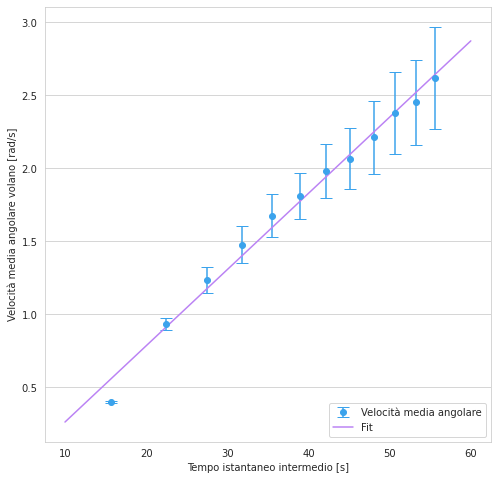

In [22]:
def plot_1acc():
    colors = iter([palette[x] for x in [12,14] ])
    
    plt.figure(figsize=(8,8))

    plt.errorbar(acc_mean, acc_vang, acc_vang_sig, fmt='o', capsize=6, color=next(colors), label='Velocità media angolare')

    X = np.linspace(10,60,10000)
    Y = [acc_fit['b'] * x + acc_fit['a'] for x in X ]
    plt.plot(X,Y, '-', color=next(colors), label='Fit')

    plt.gca().grid(axis='x')

    plt.xlabel('Tempo istantaneo intermedio [s]')
    plt.ylabel('Velocità media angolare volano [rad/s]')

    # Legend
    order = [1,0]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='lower right', ncol=1)

    plt.savefig('../grafici/graph_acc_velocita', dpi=200)

plot_1acc()

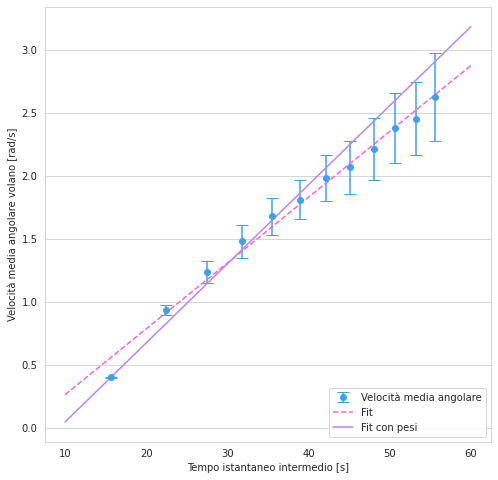

In [23]:
def plot_1acc():
    colors = iter([palette[x] for x in [12,16,14] ])
    
    plt.figure(figsize=(8,8))

    plt.errorbar(acc_mean, acc_vang, acc_vang_sig, fmt='o', capsize=6, color=next(colors), label='Velocità media angolare')

    X = np.linspace(10,60,10000)
    Y = [acc_fit['b'] * x + acc_fit['a'] for x in X ]
    plt.plot(X,Y, '--', color=next(colors), label='Fit')

    X = np.linspace(10,60,10000)
    Y = [acc_fit_pes['b'] * x + acc_fit_pes['a'] for x in X ]
    plt.plot(X,Y, color=next(colors), label='Fit con pesi')

    plt.gca().grid(axis='x')

    plt.xlabel('Tempo istantaneo intermedio [s]')
    plt.ylabel('Velocità media angolare volano [rad/s]')

    # Legend
    order = [2,0,1]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='lower right', ncol=1)

plot_1acc()

In [24]:
alpha = acc_fit['b']
alpha_sig = acc_fit['SIGb']
alpha

0.05220514895130838

In [25]:
# alpha = acc_fit_pes['b']
# alpha_sig = acc_fit_pes['SIGb']
# alpha

## Decelerazione

In [26]:
dec_mean = arr_dec.mean(axis=0)

In [27]:
dec_sdom = np.apply_along_axis(fn_sdom, 0, arr_dec)

In [28]:
dec_mean

array([ 22.43553,  46.34538,  71.05057,  96.60485, 123.0658 , 150.54508])

In [29]:
dec_sdom

array([0.44246689, 0.33247214, 0.30872754, 0.26404082, 0.26759854,
       0.21121169])

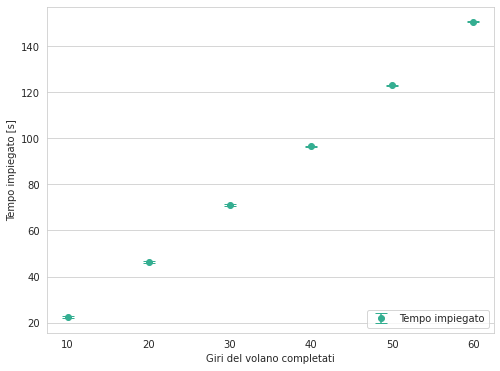

In [30]:
def plot_0dec():    
    plt.figure(figsize=(8,6))

    plt.errorbar(range(1,7), dec_mean, dec_sdom, fmt='o', capsize=6, color=palette[8], label='Tempo impiegato')

    plt.gca().grid(axis='x')

    plt.xlabel('Giri del volano completati')
    plt.ylabel('Tempo impiegato [s]')

    plt.xticks(range(1,7),range(10,70,10))
    
    plt.legend(loc='lower right')

    plt.savefig('../grafici/graph_dec_tempo', dpi=200)

plot_0dec()

### Differenza di tempo

In [31]:
dec_diff = np.apply_along_axis(
    lambda arr: np.convolve(arr, [1,-1], 'same'),
    0,
    dec_mean
)

In [32]:
dec_diff

array([22.43553, 23.90985, 24.70519, 25.55428, 26.46095, 27.47928])

#### Errore

In [33]:
dec_sdom_roll = np.roll(dec_sdom, 1, axis=0)
dec_sdom_roll[0] = 0

In [34]:
dec_diff_sigma = np.sqrt(dec_sdom**2 + dec_sdom_roll**2)
dec_diff_sigma

array([0.44246689, 0.55345702, 0.45370742, 0.40623915, 0.37593421,
       0.3409096 ])

### Velocità angolare

In [35]:
dec_vang = 2 * 10 * np.pi / dec_diff
dec_vang

array([2.80055132, 2.6278648 , 2.54326532, 2.45876045, 2.37451237,
       2.28651744])

In [36]:
dec_vang_sig = dec_diff_sigma * 2 * np.pi / dec_diff ** 2
dec_vang_sig

array([0.00552316, 0.00608289, 0.00467067, 0.00390872, 0.0033735 ,
       0.00283667])

### Fit

In [37]:
dec_fit = dict(zip(['a', 'SIGa', 'b', 'SIGb'], list(fit(dec_mean, dec_vang))))

In [38]:
dec_fit_pes = dict(zip(['a', 'SIGa', 'b', 'SIGb'], list(fit_pes(dec_mean, dec_vang, dec_vang_sig))))

### Plot

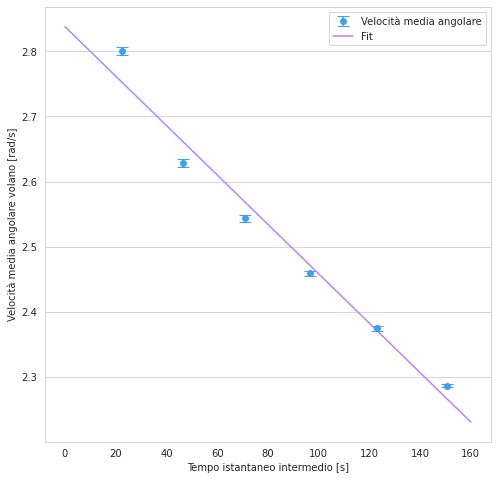

In [39]:
def plot_1dec():
    colors = iter([palette[x] for x in [12,14] ])
    
    plt.figure(figsize=(8,8))

    plt.errorbar(dec_mean, dec_vang, dec_vang_sig, fmt='o', capsize=6, color=next(colors), label='Velocità media angolare')

    X = np.linspace(0,160,10000)
    Y = [dec_fit['b'] * x + dec_fit['a'] for x in X ]
    plt.plot(X,Y, '-', color=next(colors), label='Fit')

    plt.gca().grid(axis='x')

    plt.xlabel('Tempo istantaneo intermedio [s]')
    plt.ylabel('Velocità media angolare volano [rad/s]')

    # Legend
    order = [1,0]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='upper right', ncol=1)

    plt.savefig('../grafici/graph_dec_velocita', dpi=200)

plot_1dec()

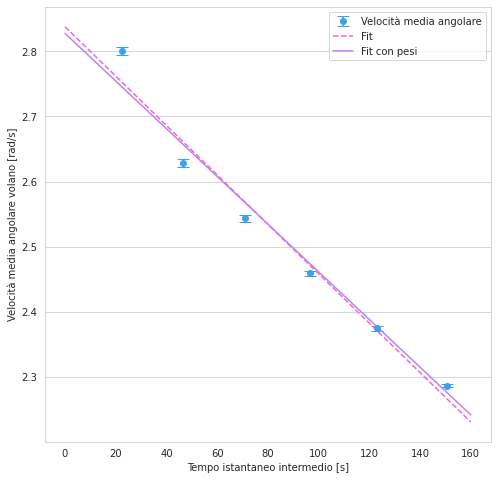

In [40]:
def plot_1dec():
    colors = iter([palette[x] for x in [12,16,14] ])
    
    plt.figure(figsize=(8,8))

    plt.errorbar(dec_mean, dec_vang, dec_vang_sig, fmt='o', capsize=6, color=next(colors), label='Velocità media angolare')

    X = np.linspace(0,160,10000)
    Y = [dec_fit['b'] * x + dec_fit['a'] for x in X ]
    plt.plot(X,Y, '--', color=next(colors), label='Fit')

    X = np.linspace(0,160,10000)
    Y = [dec_fit_pes['b'] * x + dec_fit_pes['a'] for x in X ]
    plt.plot(X,Y, color=next(colors), label='Fit con pesi')

    plt.gca().grid(axis='x')

    plt.xlabel('Tempo istantaneo intermedio [s]')
    plt.ylabel('Velocità media angolare volano [rad/s]')

    # Legend
    order = [2,0,1]
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[i] for i in order],[labels[i] for i in order], loc='upper right', ncol=1)

plot_1dec()

In [41]:
beta = dec_fit['b']
beta_sig = dec_fit['SIGb']
beta

-0.00379683609756498

In [42]:
# beta = dec_fit_pes['b']
# beta_sig = dec_fit_pes['SIGb']
# beta

## Calcolo I

In [61]:
m = 34 / 1000
m_sig = 0.5 / 1000

r = 18.95 / 1000
r_sig = 0.01 / 1000

g = 9.806
g_sig = 0.0001

In [62]:
momento_volano = (m*r*g - alpha*m*r**2)/(alpha-beta)
momento_volano

0.1128061513623801

In [63]:
partials = []

partials.append((r*(g-alpha*r)*m_sig/(alpha-beta))**2)
partials.append((m*(g-2*alpha*r)*r_sig/(alpha-beta))**2)
partials.append((m*r*g_sig/(alpha-beta))**2)
partials.append((m*r*(beta*r-g)*alpha_sig/(alpha-beta)**2)**2)
partials.append((m*r*(g-alpha*r)*beta_sig/(alpha-beta)**2)**2)

momento_volano_sig = sum(partials) ** .5
momento_volano_sig

0.003923558209904685

## Calcolo Ma

In [46]:
momento_attrito = - beta * momento_volano
momento_attrito

0.0004283064675200637

In [47]:
momento_attrito_sig = ( (beta*momento_volano_sig)**2 + (momento_volano*beta_sig)**2 ) ** .5
momento_attrito_sig

3.88371072026586e-05

## Confronto

In [48]:
momento_volano_riferimento = 0.164
momento_volano_riferimento_sig = 0.001

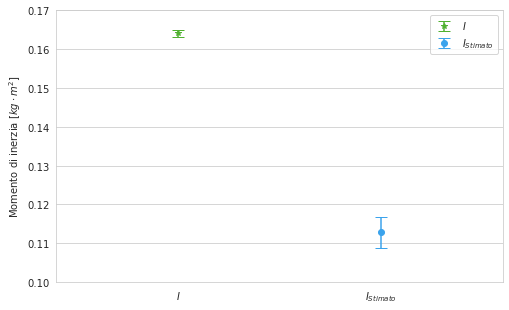

In [68]:
def plot4():
    X = [0, 1]
    Xlab = ['$I$', '$I_{Stimato}$']

    Y = [momento_volano_riferimento, momento_volano]
    Yerr = [momento_volano_riferimento_sig, momento_volano_sig]

    plt.figure(figsize=(8,5))

    plt.errorbar([0], Y[0], Yerr[0], fmt='*', capsize=6, color=palette[6], label='$I$')
    plt.errorbar([1], Y[1], Yerr[1], fmt='o', capsize=6, color=palette[12], label='$I_{Stimato}$')

    plt.gca().grid(axis='x')

    plt.xlim(-.6,1.6)
    plt.ylim(0.1,0.17)

    plt.xticks(X, Xlab)
    plt.ylabel('Momento di inerzia [$kg \\cdot m^2$]')

    plt.legend(loc='upper right')
    
    plt.savefig(graph_base_name+'stima_I', dpi=200)

plot4()